In [2]:
import json
import random
import sys,getopt
import argparse
import pandas as pd
import re
# from llama_cpp import Llama

def fetchSchema(schemapath):
    # extract tablename with columns and its foreign keys
    final = ""
    fkeys = "["
    try:
        with open(schemapath, "r", encoding="utf-8") as line:
            text = line.read()
    except: return ""
    lines = text.split("\n")
    i=1
    for i in range(len(lines)):
        if(lines[i].startswith("CREATE")):
            tablename = lines[i].split(" ")[2].strip("\"")
            final = final + "TABLE {}, columns = [*".format(tablename)
            i+=1
            while(not(lines[i].startswith("PRIMARY")) or not(lines[i].startswith("FOREIGN"))):
                final = final +","+ lines[i].split(" ")[0].strip("\"")
                i+=1
            final = final+"]\n"
        # i+=1
        if(lines[i].startswith("FOREIGN")):
            tmp = lines[i].split(" ")
            l1 = tmp[2].strip("()\"")
            l2 = tmp[4].split("(")[0].strip("\"`")
            # print(l1,l2)
            fkeys+= "{}.{} = {}.{},".format(tablename,l1,l2,l1)
        # i+=1
    fkeys+="]"
    if fkeys!= "[]":
        final+="Foreign Keys = " + fkeys 
    return final

def update_dframe(row,index,resp):
    if row['Qid'] == index:
        row['Query Generated'].append(resp)
        

# arg_list = sys.argv[1:]
# options = "nrgp:"       # n : number of questions to choose
#                         # r : number of times to repeat
#                         # g : gold file
#                         # t : test file




In [2]:
if __name__ == "__main__":
    repeat = 5
    questionSize= 5

    testFile = "../spider/dev.json"
    f = open(testFile)
    data = json.load(f)

# creating list of questions to be taken from the file. the size of the list is 'questionSize' from arguments
    lst = []
    r = random.randrange(0,len(data),1)
    for i in range(0,questionSize):
        while r in lst:
            r = random.randrange(0,len(data),1)
        lst.append(r)
    # print(lst)
    newlist = [item for item in lst for i in range(repeat)]
    
    random.shuffle(newlist)
    print(newlist)
    # print(data[854])

    result = pd.DataFrame(columns = ["Qid","Question","Query Gold","repeated","Query Generated"])
    template = "Question: Convert the following text statement to sqlite query: " 

    for index in newlist:
        # print(index)
        schemaPath = "./spider/database/{}/schema.sql".format(data[index]['db_id'])
        try:
            schema = fetchSchema(schemaPath)
        except:
            resp = "PROBLEM WITH SCHEMA RETRIEVING"
            curr = [index , data[index]['question'] , data[index]['query'],-1,resp]
            result.loc[len(result.index)] = curr
            continue
        prd = "SELECT * FROM tablename"    # get the prediction from model

        if not result[result['Qid'] == index].empty:    # already exists
            result.loc[result['Qid']==index, 'repeated']+=1
            result.apply(update_dframe,args = (index,prd),axis=1)

        else:
            curr = [index , data[index]['question'] , data[index]['query'],1,[]]
            curr[-1].append(prd)
            result.loc[len(result.index)] = curr
    



[243, 786, 294, 243, 786, 223, 786, 223, 223, 223, 786, 243, 382, 223, 294, 294, 294, 786, 243, 243, 294, 382, 382, 382, 382]


In [3]:
result.head()

,Qid,Question,Query Gold,repeated,Query Generated
0,243,Find all airlines that have fewer than 200 fli...,SELECT T1.Airline FROM AIRLINES AS T1 JOIN FLI...,5,"[SELECT * FROM tablename, SELECT * FROM tablen..."
1,786,Which unique cities are in Asian countries whe...,select distinct t3.name from country as t1 joi...,5,"[SELECT * FROM tablename, SELECT * FROM tablen..."
2,294,Find the districts in which there are both sho...,SELECT district FROM shop WHERE Number_product...,5,"[SELECT * FROM tablename, SELECT * FROM tablen..."
3,223,Which city has most number of departing flights?,SELECT T1.City FROM AIRPORTS AS T1 JOIN FLIGHT...,5,"[SELECT * FROM tablename, SELECT * FROM tablen..."
4,382,What is the total count of teachers?,SELECT count(*) FROM teacher,5,"[SELECT * FROM tablename, SELECT * FROM tablen..."


In [8]:
result['Query Gold'][0]

'SELECT T1.Airline FROM AIRLINES AS T1 JOIN FLIGHTS AS T2 ON T1.uid  =  T2.Airline GROUP BY T1.Airline HAVING count(*)  <  200'

In [17]:
testFile = "../spider/dev.json"
f = open(testFile)
data = json.load(f)
result = pd.read_csv("../consistency_results_without_schema.csv")

In [19]:
from test_eval import main

cm_exact = [[0,0],[0,0]]
cm_exec = [[0,0],[0,0]]
repeats_per_question = 5

threshold_for_consistency = 0.5
threshold_for_exact = 0.5
threshold_for_execution = 0.5


for index,row in result.iterrows():
    map = {}
    exact,exec,i,j = (0,)*4
    qid = row['Qid']
    lst = row['Query Generated'].split("\n")
    
    for r in lst:    # result will look like : {'SELECT * FROM tablename': 5}
        if r in map:
            map[r]+=1
        else: map[r] = 1
    print(map)
    for key in map:
        gold = row['Query Gold'] + "\t" + data[qid]['db_id']
        # pred = key
        pred = 'SELECT T1.Airline FROM AIRLINES AS T1 JOIN FLIGHTS AS T2 ON T1.uid  =  T2.Airline GROUP BY T1.Airline HAVING count(*)  <  200'
        m,e = main(gold,pred)    #returns the exact match and execution accuracy
        if m: exact+=map[key]
        if e : exec+=map[key]
    

    keymax = max(map,key = lambda k:map[k])
    if map[keymax]/repeats_per_question > threshold_for_consistency:
        i=0
        print(index,keymax,map[keymax])
    else: i=1

    exact = exact/repeats_per_question
    exec = exec/repeats_per_question
    
    if exact>threshold_for_exact: j=0
    else: j=1
    cm_exact[i][j]+=1

    if exec>threshold_for_execution: j=0
    else: j=1
    cm_exec[i][j]+=1


{'select address1, address2 from addresses': 1, 'select address, line1, line2 from addresses': 1, 'SELECT line1, line2 FROM addresses': 1, 'SELECT address_line_1, address_line_2 FROM addresses': 1, 'SELECT address_line1, address_line2 FROM addresses': 1}
{'SELECT avg(audience) FROM shows': 1, 'SELECT AVG(attendance) FROM shows': 1, 'SELECT AVG(audience) FROM shows': 1, 'SELECT avg(audience_size) FROM shows': 1, 'SELECT AVG(Attendance) FROM Shows': 1}
{'SELECT name FROM country ORDER BY population LIMIT 3 ': 1, 'SELECT name FROM country ORDER BY population LIMIT 3': 3, 'SELECT name FROM country ORDER BY population ASC LIMIT 3': 1}
2 SELECT name FROM country ORDER BY population LIMIT 3 3
{"SELECT pixel_aspect_ratio, country_of_origin FROM tv_channels WHERE language != 'English'": 2, 'SELECT pixel_aspect_ratio, country_of_origin FROM tv_channels WHERE language != "English"': 1, "SELECT DISTINCT pixel_aspect_ratio, country_of_origin FROM tv_channel WHERE language != 'English'": 1, 'SELECT 

<Axes: >

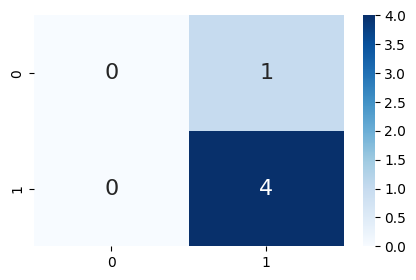

In [20]:
# import plotly.graph_objs as go
# heatmap = go.Heatmap(z=cm_exact,colorscale='Blues')
# layout = go.Layout(title='Exact Matching with Consistency')
# fig = go.Figure(data=[heatmap],layout=layout)
# fig.show()
import seaborn as sns
import matplotlib.pyplot as plt
cm = pd.DataFrame(cm_exact)

plt.figure(figsize=(5,3))
sns.heatmap(cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

<Axes: >

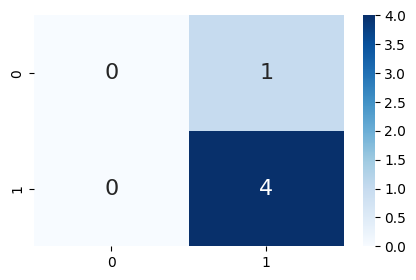

In [21]:
cm = pd.DataFrame(cm_exec)

plt.figure(figsize=(5,3))
sns.heatmap(cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

# CHEKING FOR CONSISTENCY IN ANSWERS  

#
#   1  |  2         1 - Queries are consistent and == GOLD query.  2 - Queries are consistent but != GOLD query
#   3  |  4         3 - Queries are inconsistent but == GOLD query    4 - Queries are inconsistent and != GOLD query
#
# consistent query : more than half the time returns the SAME query
# == GOLD query - 3 types of equality : Exact match, Execution accuracy, Partial Matching
result.to_csv("consistency_results.csv")

remember the extra spaces present in predicted

In [ ]:

df = pd.read_csv("../results/mistral/without_schema/mistral-7b-instruct-v0.1.Q2_K.gguf.csv")
df.head()
i=0
for (index,row) in df.iterrows():
    df.loc[index,'Query Generated'] = df.loc[index,'Query Generated'].replace(";","")
    df.loc[index,'Query Generated'] = df.loc[index,'Query Generated'].replace("```","")
    while data[i]['question'] != row['Question']:
        i+=1
        # row['Query Gold'] += "\t{}".format(data[i]['db_id'])
    df.loc[index, 'Query Gold']+= "\t{}".format(data[i]['db_id'])
    print(row['Query Gold'])
df['Query Gold'].head()

# df['Query Gold'].to_csv("../results/mistral/without_schema/GOLD",index=False,header=False)
# df['Query Generated'].to_csv("../results/mistral/without_schema/PRED",index=False,header=False)

In [108]:
import numpy as np
np.savetxt("../results/mistral/without_schema/GOLD",df['Query Gold'].values,fmt = "%s")
np.savetxt("../results/mistral/without_schema/PRED",df['Query Generated'].values,fmt = "%s")

Palm

In [ ]:
df = pd.read_csv("../results/Palm/without_schema/palm_without_schema.csv")
df.head()
i=0
for (index,row) in df.iterrows():
    try:
        df.loc[index,'Query Generated'] = df.loc[index,'Query Generated'].replace(";","")
        df.loc[index,'Query Generated'] = df.loc[index,'Query Generated'].replace("```","")
    except: None
    while data[i]['question'] != row['Question']:
        i+=1
        # row['Query Gold'] += "\t{}".format(data[i]['db_id'])
    df.loc[index, 'Query Gold']+= "\t{}".format(data[i]['db_id'])
    print(row['Query Gold'])
df['Query Generated'] = df['Query Generated'].str.replace(r';.*', '',regex=True)
df['Query Gold'].head()
df['Query Gold'].to_csv("../results/Palm/without_schema/GOLD" ,index=False,header=False)
df['Query Generated'].to_csv("../results/Palm/without_schema/PRED",index=False,header=False)


In [128]:
np.savetxt("../results/Palm/without_schema/GOLD",df['Query Gold'].values,fmt = "%s")
np.savetxt("../results/Palm/without_schema/PRED",df['Query Generated'].values,fmt = "%s")

In [17]:
df = pd.read_csv("../results/Palm/with_schema/palm_with_schema.csv")
df.head()
i=0
for (index,row) in df.iterrows():
    try:
        df.loc[index,'Query Generated'] = df.loc[index,'Query Generated'].replace(";","")
        df.loc[index,'Query Generated'] = df.loc[index,'Query Generated'].replace("```","")
        df.loc[index,'Query Generated'] = df.loc[index,'Query Generated'].replace("\n"," ")
        df['Query Generated'] = df['Query Generated'].str.strip()   # remove trailing white spaces
        df['Query Generated'] = df['Query Generated'].str.replace(r'\s+', ' ',regex=True)
    except: None
    while data[i]['question'] != row['Question']:
        i+=1
        # row['Query Gold'] += "\t{}".format(data[i]['db_id'])
    df.loc[index, 'Query Gold']+= "\t{}".format(data[i]['db_id'])
    print(row['Query Gold'])
df['Query Generated'] = df['Query Generated'].str.replace(r';.*', '',regex=True)
df['Query Gold'].head()
df['Query Gold'].to_csv("../results/Palm/with_schema/GOLD" ,index=False,header=False)
df['Query Generated'].to_csv("../results/Palm/with_schema/PRED",index=False,header=False)


SELECT count(*) FROM singer
SELECT count(*) FROM singer
SELECT name ,  country ,  age FROM singer ORDER BY age DESC
SELECT name ,  country ,  age FROM singer ORDER BY age DESC
SELECT avg(age) ,  min(age) ,  max(age) FROM singer WHERE country  =  'France'
SELECT avg(age) ,  min(age) ,  max(age) FROM singer WHERE country  =  'France'
SELECT song_name ,  song_release_year FROM singer ORDER BY age LIMIT 1
SELECT song_name ,  song_release_year FROM singer ORDER BY age LIMIT 1
SELECT DISTINCT country FROM singer WHERE age  >  20
SELECT DISTINCT country FROM singer WHERE age  >  20
SELECT country ,  count(*) FROM singer GROUP BY country
SELECT country ,  count(*) FROM singer GROUP BY country
SELECT song_name FROM singer WHERE age  >  (SELECT avg(age) FROM singer)
SELECT song_name FROM singer WHERE age  >  (SELECT avg(age) FROM singer)
SELECT LOCATION ,  name FROM stadium WHERE capacity BETWEEN 5000 AND 10000
SELECT LOCATION ,  name FROM stadium WHERE capacity BETWEEN 5000 AND 10000
select max

In [18]:
np.savetxt("../results/Palm/with_schema/GOLD",df['Query Gold'].values,fmt = "%s")
np.savetxt("../results/Palm/with_schema/PRED",df['Query Generated'].values,fmt = "%s")

for WIZARD try querying model without explanation
only in some queries ; is not present
in the current results - try to remove all lines after \```
                         if the line starts with \```sql then the query lies b/w both \```. then remove all lines after ```

WIZARD with schema is NOT good. It is overusing information. too many joins
but can check for execution accuracy maybe. Not worth checking EXACT MATCH ACCURACY

for LLama, if the line starts with \```sql then the query lies b/w both \```. then remove all lines after ```
            else remove everything after ';' or \```. present for all queries

FLAN-T5


In [19]:
import pandas as pd
import numpy as np
import json

testFile = "../spider/dev.json"

f = open(testFile)
data = json.load(f)

df = pd.read_csv("../results/Flan-t5/without_schema/without_schema.csv")
df.head()
i=0
for (index,row) in df.iterrows():
    # print(row)
    print("start :", i)
    while data[i]['question'] != row['Question']:
        i+=1
    print("end :" ,i)
    df.loc[index, 'Query Gold']+= "\t{}".format(data[i]['db_id'])
    print(row['Query Gold'])
df['Query Gold'].head()

np.savetxt("../results/Flan-t5/without_schema/GOLD",df['Query Gold'].values,fmt = "%s")
np.savetxt("../results/Flan-t5/without_schema/PRED",df['Query Generated'].values,fmt = "%s")

start : 0
end : 0
SELECT count(*) FROM singer
start : 0
end : 1
SELECT count(*) FROM singer
start : 1
end : 2
SELECT name ,  country ,  age FROM singer ORDER BY age DESC
start : 2
end : 3
SELECT name ,  country ,  age FROM singer ORDER BY age DESC
start : 3
end : 4
SELECT avg(age) ,  min(age) ,  max(age) FROM singer WHERE country  =  'France'
start : 4
end : 5
SELECT avg(age) ,  min(age) ,  max(age) FROM singer WHERE country  =  'France'
start : 5
end : 6
SELECT song_name ,  song_release_year FROM singer ORDER BY age LIMIT 1
start : 6
end : 7
SELECT song_name ,  song_release_year FROM singer ORDER BY age LIMIT 1
start : 7
end : 8
SELECT DISTINCT country FROM singer WHERE age  >  20
start : 8
end : 9
SELECT DISTINCT country FROM singer WHERE age  >  20
start : 9
end : 10
SELECT country ,  count(*) FROM singer GROUP BY country
start : 10
end : 11
SELECT country ,  count(*) FROM singer GROUP BY country
start : 11
end : 12
SELECT song_name FROM singer WHERE age  >  (SELECT avg(age) FROM si

In [13]:
print(data[296]['question'])
print(data[297]['question'])
print(data[298]['question'])

Count the number of distinct store locations.
How many documents do we have?
Count the number of documents.
